In [4]:
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder



base_dir = 'dataset'

def load_data(directory, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    data = ImageFolder(directory, transform=transform)
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)
    return data_loader


train_loader = load_data(os.path.join(base_dir, 'Train'))
validation_loader = load_data(os.path.join(base_dir, 'Validation'))
test_loader = load_data(os.path.join(base_dir, 'Test'))

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 4)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [10]:
import torch
from torch import nn

def train_model(model, train_loader, valid_loader, num_epochs=10, learning_rate=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Lists to track the losses and accuracies
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        average_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(average_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():  # No gradients needed for validation
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        average_val_loss = running_val_loss / len(valid_loader)
        val_accuracy = 100 * correct_val / total_val
        valid_losses.append(average_val_loss)
        valid_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch + 1}, Train Loss: {average_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {average_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
    
    return model, train_losses, valid_losses, train_accuracies, valid_accuracies


In [11]:
import matplotlib.pyplot as plt

def plot_metric(train_metric, valid_metric, metric_name, save_path='figures/img.png'):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label=f'Training {metric_name}')
    plt.plot(valid_losses, label=f'Validation Loss {metric_name}')
    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.savefig(save_path)


In [13]:
model = CNN()  # Assuming CNN is your model class
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, train_loader, validation_loader)

Epoch 1, Train Loss: 1.0307, Train Acc: 57.67%, Val Loss: 0.6523, Val Acc: 70.14%
Epoch 2, Train Loss: 0.5353, Train Acc: 78.20%, Val Loss: 0.5108, Val Acc: 81.08%
Epoch 3, Train Loss: 0.3676, Train Acc: 86.31%, Val Loss: 0.4395, Val Acc: 82.81%
Epoch 4, Train Loss: 0.2081, Train Acc: 92.46%, Val Loss: 0.4395, Val Acc: 86.46%
Epoch 5, Train Loss: 0.1170, Train Acc: 95.90%, Val Loss: 0.4282, Val Acc: 86.11%
Epoch 6, Train Loss: 0.0461, Train Acc: 98.65%, Val Loss: 0.4651, Val Acc: 88.72%
Epoch 7, Train Loss: 0.0274, Train Acc: 99.26%, Val Loss: 0.5887, Val Acc: 87.67%
Epoch 8, Train Loss: 0.0676, Train Acc: 98.17%, Val Loss: 0.6406, Val Acc: 87.33%
Epoch 9, Train Loss: 0.0672, Train Acc: 98.04%, Val Loss: 0.4041, Val Acc: 89.58%
Epoch 10, Train Loss: 0.0237, Train Acc: 99.08%, Val Loss: 0.6730, Val Acc: 88.02%


In [ ]:
import pickle


with open('train_data.pkl', 'wb') as f:
    pickle.dump({'': })

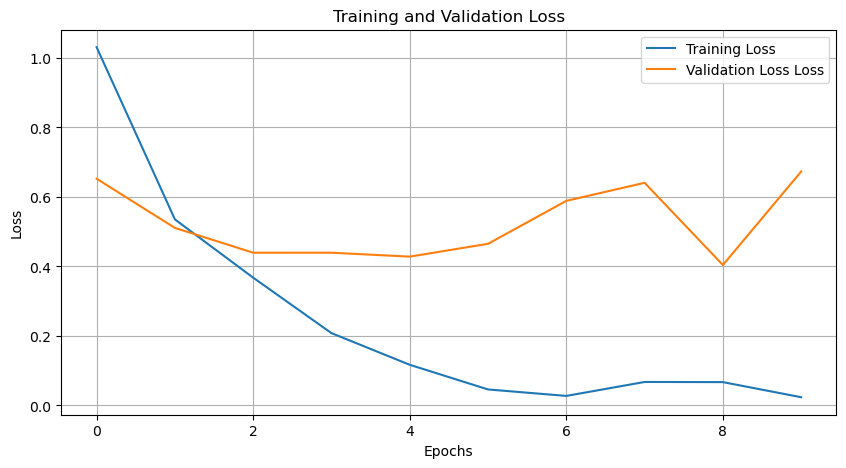

In [14]:
# Now plot the losses
plot_metric(train_losses, valid_losses, 'Loss')

In [15]:
def save_model(model, path='model.pth'):
    torch.save(model.state_dict(), path)

def load_model(path='model.pth'):
    model = CNN()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

# Example usage:
save_model(trained_model)
# loaded_model = load_model()

In [17]:
!pip3 install torchviz

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.5 MB/s eta 0:00:00
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=15bdd31a0f9f50c7a0bc047f14893fdb7102921c31fa85ff852a9269023ccb9a
  Stored in directory: /sfs/qumulo/qhome/jax4zk/.cache/pip/wheels/5a/d0/3f/b7014553eb74f12892b7d9b69c6083044564712d10fde8dfdc
Successfully built torchviz


In [18]:
from torchviz import make_dot

def visualize_model(model, input_size=(3, 150, 150)):
    # Create a dummy input tensor with the correct size
    dummy_input = torch.randn(1, *input_size, requires_grad=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dummy_input = dummy_input.to(device)
    model = model.to(device)
    
    # Forward pass through the model
    output = model(dummy_input)
    
    # Create dot graph of the model
    dot = make_dot(output, params=dict(list(model.named_parameters()) + [('input', dummy_input)]))
    return dot

# Example usage:
dot = visualize_model(model)
dot.render('model_visualization', format='png', cleanup=True)  # This saves the diagram as a PNG


'model_visualization.png'